In [3]:
# Loading Packages
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import copy
import glob
import os
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import KFold

In [73]:
def generateData(t, k, u, error):
    
    dt = t[1] - t[0]
    ut = np.zeros(u.shape)

    #compute derivative
    for i in np.arange(1,len(u)-1):
        ut[i] = (u[i+1] - u[i-1])/(2*dt)
    ut[0] = (u[1] - u[0])/dt
    ut[-1] = (u[-1] - u[-2])/dt

    variables = [t[:,np.newaxis],u[:,np.newaxis],ut[:,np.newaxis]]
    variable_names = ['t','u','u_t']
    
    variables = [t[:,np.newaxis],u[:,np.newaxis],ut[:,np.newaxis]]
    
    #U values
    U = copy.deepcopy(variables[1])

    for i in range(len(U)):
        U[i] = U[i] + random.normal(loc=0, scale=error)
    #Ut vector
    Ut = copy.deepcopy(ut)

    for i in range(len(Ut)):
        Ut[i] = Ut[i] + random.normal(loc=0, scale=error)
        
    description = ['u^0','u^1','u^2','u^3','u^4','u^5','u^6','u^7','u^8']
    
    
    plt.figure()
    plt.plot(t,u,'blue')
    plt.plot(t,ut,'r')
    plt.scatter(t,U,s=3,facecolors='none', edgecolors='b')
    plt.scatter(t,Ut,s=3,facecolors='none', edgecolors='r')
    plt.show()
    
    Theta = np.hstack((np.ones(U.shape),U ,U**2,U**3, U**4, U**5, U**6, U**7, U**8))
    Theta = preprocessing.scale(Theta)
    Theta[:, 0] = 1
    dim = len(description)
    return Theta, Ut, len(description), description

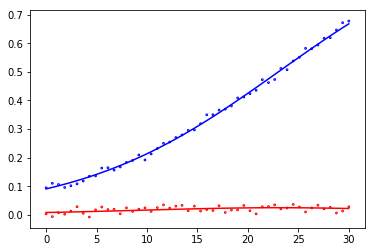

Full regression predicts the ODE model:

Ridge + CV - regression predicts the ODE model:
Best BIC = -322.4815523849588
Ut = 
-0.12817216349185628 u^2 + 
0.11508441373083021 u^1

Lasso + CV - regression predicts the ODE model:
Best BIC = -301.66107529881305
Ut = 
0.021301129783065156 u^1

Relaxed Lasso - regression predicts the ODE model:
Best BIC = -301.66107529881305
Ut = 
0.021301129783065156 u^1


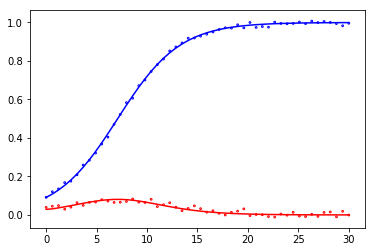

Full regression predicts the ODE model:

Ridge + CV - regression predicts the ODE model:
Best BIC = -235.62030145882588
Ut = 
0.2630476398894538 u^7 + 
-0.6228310215163407 u^5 + 
0.31231074513214324 u^3

Lasso + CV - regression predicts the ODE model:
Best BIC = -310.8158120162498
Ut = 
-0.29542269406383337 u^2 + 
0.29302351936108073 u^1

Relaxed Lasso - regression predicts the ODE model:
Best BIC = -253.98512126757757
Ut = 
-0.11199713652213472 u^5 + 
0.07496634665933351 u^1


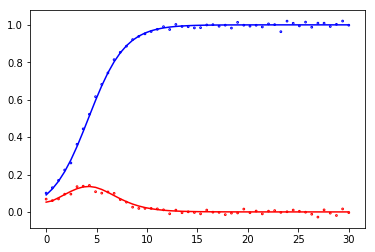

Full regression predicts the ODE model:

Ridge + CV - regression predicts the ODE model:
Best BIC = -249.47213923199072
Ut = 
0.4387705127020315 u^4 + 
-0.856663950149164 u^3 + 
0.4022281708700447 u^1

Lasso + CV - regression predicts the ODE model:
Best BIC = -293.9856897687069
Ut = 
-0.503067404453506 u^2 + 
0.48888765428469105 u^1

Relaxed Lasso - regression predicts the ODE model:
Best BIC = -206.63390399626329
Ut = 
-0.10566121801663354 u^6


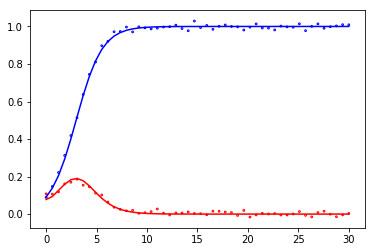

Full regression predicts the ODE model:

Ridge + CV - regression predicts the ODE model:
Best BIC = -214.95785496224926
Ut = 
0.3950990649023205 u^5 + 
-0.7406431133006927 u^4 + 
0.2766156387115597 u^1

Lasso + CV - regression predicts the ODE model:
Best BIC = -220.9481494256652
Ut = 
-0.3628205697328514 u^3 + 
0.29407769058209354 u^1

Relaxed Lasso - regression predicts the ODE model:
Best BIC = -190.26205544442607
Ut = 
-0.14163517232452935 u^7


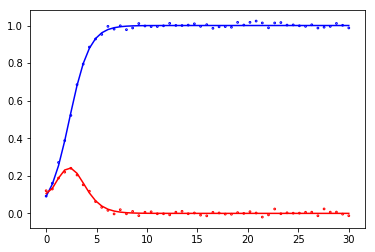

Full regression predicts the ODE model:

Ridge + CV - regression predicts the ODE model:
Best BIC = -219.77859417778654
Ut = 
1.0452009657729155 u^5 + 
-1.5950577375842352 u^4 + 
0.48879217301857686 u^1

Lasso + CV - regression predicts the ODE model:
Best BIC = -178.1389455123751
Ut = 
-0.1819447134890206 u^6

Relaxed Lasso - regression predicts the ODE model:
Best BIC = -178.1389455123751
Ut = 
-0.1819447134890206 u^6


In [72]:
# Change to whatever you want to iterate on
for k in np.linspace(0.1,1,5):
    t = np.linspace(0,30,50)
    u = np.exp(k*t)/(10 + np.exp(k*t))
    Theta, Ut, dim, description = generateData(t, k, u, error = 0.01)
    
    print "Full regression predicts the ODE model:"
    #print linear_model.LinearRegression().fit(Theta,Ut).coef_

    #print ""
    #print "Bootstrap Model Selection - regression predicts the ODE model:"
    #bootSelect(Theta, Ut, dim = dim, description = description, reg = linear_model.LassoCV(alphas = np.linspace(0.001, 0.01, 100), cv = 10))

    #print ""
    #print "Ridge + Boot - regression predicts the ODE model:"
    #Ridge_Boot(Theta, Ut, dim = dim, description = description)

    print ""
    print "Ridge + CV - regression predicts the ODE model:"
    #1 loop, best of 3: 1.9 s per loop %timeit
    Ridge_CV(Theta, Ut, dim = dim, description = description, InCr = "BIC")

    print ""
    print "Lasso + CV - regression predicts the ODE model:"
    # 10 loops, best of 3: 126 ms per loop %timeit 
    Ridge_CV(Theta, Ut, dim = dim, model = linear_model.LassoCV, description = description, InCr = "BIC")

    #print ""
    #print "ElasticNet + CV - regression predicts the ODE model:"
    #Ridge_CV(Theta, Ut, dim = dim, model = linear_model.ElasticNetCV, description = description, InCr = "BIC")


    print ""
    print "Relaxed Lasso - regression predicts the ODE model:"
    #1 loop, best of 3: 286 ms per loop %timeit
    relaxedLasso(Theta, Ut, dim = dim, description = description, InCr = "BIC")

In [4]:
def Ridge_Boot(Theta, Ut, dim, description):
    ##Cross Validation
    from sklearn.model_selection import KFold
    from sklearn.linear_model import RidgeCV

    best_lambda_tol = None
    best_d_tol = None
    best_meanOfResiduals = 100000000
    best_pde = None
    
    #clf = RidgeCV(alphas=np.linspace(0.000001, 0.00001, 50)).fit(Theta, Ut)
    return bootSelect(Theta, Ut, dim, description, reg = RidgeCV(alphas=np.linspace(0.001, 0.001, 50)))

In [5]:
def bootSelect(Theta, Ut, dim, description, Bag = 100, reg = linear_model.LinearRegression()):
    from sklearn import linear_model
    from sklearn.utils import resample
    boot_reg_coef = []
    for i in range(Bag):
        X, y = resample(Theta, Ut, replace=True)
        reg.fit(X, y)
        boot_reg_coef.append(reg.coef_)
    boot_reg_coef = np.array(boot_reg_coef)
    #print(boot_reg_coef)
    
    for i in range(dim):
        coef = boot_reg_coef[:, i]
        coef = np.sort(coef)
        print description[i] + ":[" + str(coef[int(0.10 * Bag)]) + " , " + str(coef[int(0.90 * Bag)]) + "]"
    
    reg_coef = []
    k = len(boot_reg_coef)
    for i in range(dim):
        coef = boot_reg_coef[:, i]
        coef = np.sort(coef)
        if coef[int(0.10 * Bag)] < 0 and coef[int(0.90 * Bag)] > 0:
            reg_coef.append(0)
        else:
            reg_coef.append(np.mean(coef))
    return bestSubsetSelection(Theta, Ut, reg_coef, description)

In [66]:
def Ridge_CV(Theta, Ut, dim, description, model = linear_model.RidgeCV, InCr = "AIC"):

    best_lambda_tol = None
    best_d_tol = None
    best_sumOfResiduals = 100000000
    best_pde = []
    
    RidgeResult = model(alphas = np.linspace(0.000001, 0.01, 100), cv = 10).fit(Theta, Ut)
    best_lambda_tol = RidgeResult.alpha_
    #if model == linear_model.RidgeCV:
    #    RidgeResult.coef_ = RidgeResult.coef_[0]
    
    sortedCoef = np.sort(abs(RidgeResult.coef_))
    ## mini = index of the sortedCoef
    mini = 0
    #Swapping unnecessary Betas into zero
    # Trying rule of thumb as sortedCoef[dim - 1]/3
    for d_tol in np.linspace(0, sortedCoef[dim - 1]/2, 50):
        if sortedCoef[mini] >= d_tol:
            # Skip
            continue
        for j in range(dim):
            curCoef = abs(RidgeResult.coef_[j])
            if curCoef < d_tol:
                # update mini
                while sortedCoef[mini] <= curCoef:
                    mini = mini + 1
                RidgeResult.coef_[j] = 0
        
        kf = KFold(n_splits=10, shuffle=True)
        residualList = []
        for train, test in kf.split(Ut):
            sumOfResiduals = np.linalg.norm(Ut[test] - Theta[test].dot(np.transpose(RidgeResult.coef_)))
            residualList.append(sumOfResiduals)
        sumOfResiduals = np.sum(residualList)
        if best_sumOfResiduals > sumOfResiduals:
            best_d_tol = d_tol
            best_pde = RidgeResult.coef_
            best_sumOfResiduals = sumOfResiduals
    #print "best_lambda_tol = " + str(best_lambda_tol)
    #print "best_d_tol = " + str(best_d_tol)
    #print "best_pde = " + str(RidgeResult.coef_)
    #print "best_sumOfResiduals = " + str(best_sumOfResiduals)
    return bestSubsetSelection(Theta, Ut, best_pde, description, InCr = InCr)

In [62]:
def bestSubsetSelection(Theta, Ut, best_pde, description, InCr = "AIC"):
    Theta = np.transpose(Theta)
    best_IC = 100000000
    best_reg = []
    best_subset = []
    #sublib = [non-zero indices]
    sublib = []
    for i in range(len(best_pde)):
        if best_pde[i] != 0:
            sublib.append(i)
    
    Theta_new = copy.deepcopy(Theta[sublib])
    
    # Best Subset Selection ** expensive
    sublib_size = len(sublib)
    description = np.array(description)

    for i in range(1, 2**sublib_size):
        subset = []
        j = i
        cur = sublib_size - 1
        while j:
            if j & 1:
                subset.append(cur)
            cur = cur - 1
            j = j >> 1
        
        reg, IC = getIC(np.transpose(Theta_new[subset]), Ut, len(subset), InCr = InCr)
        if IC < best_IC:
            best_IC = IC
            best_reg = reg
            best_subset = subset
    if not len(best_reg):
        print "Null Model"
        return
    
    print "Best " + InCr + " = " + str(IC)
    print "Ut = "
    for i in range(len(best_reg) - 1):
        print str(best_reg[i]) + " " + str(description[sublib][best_subset][i]) + " + "
    print str(best_reg[len(best_reg) - 1]) + " " + str(description[sublib][best_subset][len(best_reg) - 1])
    return reg, IC

In [8]:
def subsetData(Theta, best_pde, description):
    Theta = np.transpose(Theta)
    best_reg = []
    best_subset = []
    #sublib = [non-zero indices]
    sublib = []
    for i in range(len(best_pde)):
        if best_pde[i] == 0:
            sublib.append(i)
    Theta_new = copy.deepcopy(Theta)
    Theta_new[sublib] = 0
    description = np.array(description)
    return np.transpose(Theta_new), description[sublib]

In [64]:
def getIC(Theta, Ut, p, InCr = "AIC"):
    from sklearn import linear_model
    reg = linear_model.LinearRegression()
    reg.fit(Theta, Ut)
    n = len(Ut)
    sumOfResiduals = np.linalg.norm(Ut - Theta.dot(np.transpose(reg.coef_)))
    ICDict = {"AIC": n*np.log(sumOfResiduals)+2*p,
              "BIC": n*np.log(sumOfResiduals/n)+p*np.log(n)}
    return reg.coef_, ICDict[InCr]
# "AIC": n*np.log(sumOfResiduals)+2*p

In [69]:
def relaxedLasso(Theta, Ut, dim, description, InCr = "AIC"):
    best_coef = linear_model.LassoCV(alphas = np.linspace(0.0001, 0.01, 100), cv = 10).fit(Theta, Ut).coef_
    Theta_new, description_new = subsetData(Theta, best_coef, description)
    second_coef = linear_model.LassoCV(alphas = np.linspace(0.00001, 0.001, 100), cv = 10).fit(Theta_new, Ut).coef_
    return bestSubsetSelection(Theta, Ut, second_coef, description, InCr = InCr)